<a href="https://colab.research.google.com/github/aravindchakravarti/ONNX_TensorRT/blob/main/MNIST_Classifier_ONNX_TRT_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
import torch
# Import core module
import torch.nn as nn
# We need support for functional programming
import torch.nn.functional as F
import torch.optim as optim
# For MNIST dataset
from torchvision import datasets, transforms
# For Global Average Pooling
from torch.nn import AvgPool2d

# For displaying images
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# You cannot live without Numpy in Python! :-D
import numpy as np

# 1. Define the model, load dataset and train!

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)      #I=28, O=28, RF=3
        self.batch1 = nn.BatchNorm2d(num_features=8)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1)      #I=28, O=28, RF=5
        self.batch2 = nn.BatchNorm2d(num_features=8)
        self.conv3 = nn.Conv2d(8, 12, 3, padding=1)     #I=28, O=28, RF=7
        self.batch3 = nn.BatchNorm2d(num_features=12)
        self.pool1 = nn.MaxPool2d(2, 2)                 #I=28, O=14, RF=14
        self.conv4 = nn.Conv2d(12, 10, 1)

        self.conv5 = nn.Conv2d(10, 16, 3, padding=1)    #I=14, O=14, RF=17
        self.batch4 = nn.BatchNorm2d(num_features=16)
        self.conv6 = nn.Conv2d(16, 16, 3, padding=1)    #I=14, O=14, RF=20
        self.batch5 = nn.BatchNorm2d(num_features=16)
        self.conv7 = nn.Conv2d(16, 16, 3, padding=1)    #I=14, O=14, RF=23
        self.batch6 = nn.BatchNorm2d(num_features=16)
        self.pool2 = nn.MaxPool2d(2, 2)                 #I=14, O=07, RF=26
        self.conv8 = nn.Conv2d(16, 10, 1)

        self.conv9 = nn.Conv2d(10, 32, 3, padding=0)    #I=07, O=05, RF=29
        self.batch7 = nn.BatchNorm2d(num_features=32)
        self.conv10 = nn.Conv2d(32, 10, 3, padding=0)   #I=05, O=03, RF=32
        self.batch8 = nn.BatchNorm2d(num_features=10)
        self.avg_pool = nn.AvgPool2d(kernel_size=3)

    def forward(self, x):
        x = self.batch1(F.relu(self.conv1(x)))        #See above for Input\
        x = self.batch2(F.relu(self.conv2(x)))        #Output and Receptive Field
        x = self.batch3(F.relu(self.conv3(x)))
        x = self.pool1(x)
        x = F.relu(self.conv4(x))

        x = self.batch4(F.relu(self.conv5(x)))
        x = self.batch5(F.relu(self.conv6(x)))
        x = self.batch6(F.relu(self.conv7(x)))
        x = self.pool2(x)
        x = F.relu(self.conv8(x))

        x = self.batch7(F.relu(self.conv9(x)))
        x = self.batch8(F.relu(self.conv10(x)))
        x = self.avg_pool(x)
        x = x.view(-1, 10)                           # Don't want 10x1x1..
        return F.log_softmax(x)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3            [-1, 8, 28, 28]             584
       BatchNorm2d-4            [-1, 8, 28, 28]              16
            Conv2d-5           [-1, 12, 28, 28]             876
       BatchNorm2d-6           [-1, 12, 28, 28]              24
         MaxPool2d-7           [-1, 12, 14, 14]               0
            Conv2d-8           [-1, 10, 14, 14]             130
            Conv2d-9           [-1, 16, 14, 14]           1,456
      BatchNorm2d-10           [-1, 16, 14, 14]              32
           Conv2d-11           [-1, 16, 14, 14]           2,320
      BatchNorm2d-12           [-1, 16, 14, 14]              32
           Conv2d-13           [-1, 16, 14, 14]           2,320
      BatchNorm2d-14           [-1

<ipython-input-2-6a328491a770>:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


100%|██████████| 9912422/9912422 [00:00<00:00, 120146083.71it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 98805623.02it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 28592832.65it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6219565.38it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    # Disabling TQDM. Don't want to hurt CPU on my machine
    #pbar = tqdm(train_loader)
    #       If you enable TQDM, replace to pbar-- below
    #                                           |
    #                                           ▼
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        #pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
# Assign model to GPU and start training. I am training here only for 1 epoch as 90+ % accuracy is
# sufficient for my experiment
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 2):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

<ipython-input-2-6a328491a770>:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Average loss: 0.0814, Accuracy: 9820/10000 (98.20%)



# 2. Inferencing using Model

 Charecter is ➡ 8 


<ipython-input-2-6a328491a770>:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


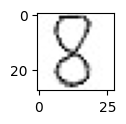

In [ ]:
# Turn the modelto inference only
model.eval()

# Read the image, scale it to 28x28 and convert it into Grayscale
img = cv2.imread('/content/eight.jpg')
img = cv2.resize(img, (28,28))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

'''
To match to MNIST dataset, we need to invert the image
for more information check here -->
https://stackoverflow.com/questions/58631088/why-are-my-neural-network-predictions-correct-when-applied-to-mnist-hand-drawn-i
'''
img= cv2.bitwise_not(img) # invert image
plt.figure(figsize = (1,1))
plt.imshow(img, cmap = plt.cm.binary)

# Bring the image between 0->1 and perform zero mean, unit variance
img = img.astype(np.float32)
img = img/255
img = (img-0.1307)/0.3081

# We need image size as batch x channels x width x height
img = np.expand_dims(img, 0)
img = np.expand_dims(img, 0)
img = torch.from_numpy(img).to(device)

# Run the inference and get the max out from the neural network
output = model(img)
#print (output)
pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
pred = pred.detach().cpu().numpy()

print ('\x1b[1;31m \x1b[0;31m' + "Charecter is ➡ {} ".format(pred.flatten()[0]) + '\x1b[0m')


#3. Convert to ONNX and inference using ONNX

In [ ]:
!pip install onnx
!pip install onnxruntime
!pip install onnxscript

import onnx
import onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 551.2/551.2 kB 3.4 MB/s eta 0:00:00


In [ ]:
ONNX_FILE_PATH = 'MNIST_Classifier.onnx'

# we need to give sample input the ONNX converter. Since, model work on 4 dimensions, 4th dimension being batch size,
# we give batch size as 1.
dummy_input = torch.randn(1, 1, 28, 28, device="cuda") # 1080, 1920, device="cuda")
#dummy_input = dummy_input.half()

with torch.no_grad():
   model = model.to(device)
   torch_out = model(dummy_input)

# Export the model to ONNX
torch.onnx.export(model,
                  dummy_input,
                  ONNX_FILE_PATH,
                  opset_version = 12,
                  input_names=['images'],
                  output_names=['output0'],
                  export_params=True)

# If converted model has any error, then it will checker will give error!
onnx_model = onnx.load('/content/MNIST_Classifier.onnx')
onnx.checker.check_model(onnx_model)

<ipython-input-2-6a328491a770>:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
# Let us create the ONNX run time with the ONNX file which we generated before
ort_session = onnxruntime.InferenceSession("/content/MNIST_Classifier.onnx")

def to_numpy(tensor):
    print ("Type = {}".format(type(tensor)))
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(dummy_input)}
ort_outs = ort_session.run(None, ort_inputs)

print ("torch_out size = {}".format(torch_out.shape))
print ("ort_outs[0] size = {}".format((ort_outs[0]).shape))

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Type = <class 'torch.Tensor'>
torch_out size = torch.Size([1, 10])
ort_outs[0] size = (1, 10)
Type = <class 'torch.Tensor'>
Exported model has been tested with ONNXRuntime, and the result looks good!


Type = <class 'torch.Tensor'>
 Charecter is ➡ 7 


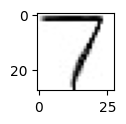

In [ ]:
# Read the image, scale it to 28x28 and convert it into Grayscale
img = cv2.imread('/content/seven.jpg')
img = cv2.resize(img, (28,28))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

'''
To match to MNIST dataset, we need to invert the image
for more information check here -->
https://stackoverflow.com/questions/58631088/why-are-my-neural-network-predictions-correct-when-applied-to-mnist-hand-drawn-i
'''
img= cv2.bitwise_not(img) # invert image
plt.figure(figsize = (1,1))
plt.imshow(img, cmap = plt.cm.binary)

# Bring the image between 0->1 and perform zero mean, unit variance
img = img.astype(np.float32)
img = img/255
img = (img-0.1307)/0.3081

# We need image size as batch x channels x width x height
img = np.expand_dims(img, 0)
img = np.expand_dims(img, 0)
img = torch.from_numpy(img).to(device)

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img)}
ort_outs = ort_session.run(None, ort_inputs)

ort_outs_tensor = torch.from_numpy(ort_outs[0])
#print(ort_outs_tensor.shape)

pred = ort_outs_tensor.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
pred = pred.detach().cpu().numpy()

print ('\x1b[1;31m \x1b[0;31m'+"Charecter is ➡ {} ".format(pred.flatten()[0])+'\x1b[0m')

# 4. Converting the model to tensorRT and inferencing it

In [ ]:
!pip install --upgrade setuptools pip --user
!pip install --ignore-installed PyYAML
!pip install Pillow

!pip install nvidia-pyindex
!pip install --upgrade nvidia-tensorrt
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.5/819.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.4 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.5/705.5 kB 4.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-pyindex: filename=nvidia_pyindex-1.0.9-py3-none-any.whl size=8418 sha256=368997bdbe7c09ce72f3a5ecac435d50264dd5cb2e41598cf05b2d6e9536e4c2
  Stored in directory: /root/.cache/pip/wheels/2c/af/d0/7a12f82cab69f65d51107f48bcd6179e29b9a69a90546332b3
Successfully built nvidia-pyindex
  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-8.6.1.post1-py2.py3-none-any.whl size=17283 sha256=7fcb5a6fa9e6a42b84e86fbf32fd441366d55ba112cd63aae614569233e712bc
  Stored in directory: /root/.cache/pip/wheels/f4/c8/0e/b79b08e45752491b9acfdbd69e8a609e8b2ed7640dda5a3e59
Successfully built tensorrt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [ ]:
from collections import OrderedDict,namedtuple
import tensorrt as trt
import time

In [ ]:
# Download ONNX to TensorRT converter
%cd /content/
!git clone https://github.com/Linaom1214/tensorrt-python.git

%cd tensorrt-python
!ls

/content
Cloning into 'tensorrt-python'...
remote: Enumerating objects: 337, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 337 (delta 61), reused 57 (delta 57), pack-reused 254
Receiving objects: 100% (337/337), 132.56 MiB | 38.35 MiB/s, done.
Resolving deltas: 100% (169/169), done.
/content/tensorrt-python
cpp  export.py	image_batch.py	README_CN.md  README.md  src  trt.py  utils


In [ ]:
# Export TensorRT-engine model
!python export.py -o /content/MNIST_Classifier.onnx -e ./MNIST_Classifier_engine.trt -p fp32

Namespace(onnx='/content/MNIST_Classifier.onnx', engine='./MNIST_Classifier_engine.trt', precision='fp32', verbose=False, workspace=1, calib_input=None, calib_cache='./calibration.cache', calib_num_images=5000, calib_batch_size=8, end2end=False, conf_thres=0.4, iou_thres=0.5, max_det=100, v8=False)
[01/11/2024-06:11:39] [TRT] [I] [MemUsageChange] Init CUDA: CPU +1, GPU +0, now: CPU 27, GPU 545 (MiB)
[01/11/2024-06:11:53] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU +888, GPU +174, now: CPU 992, GPU 719 (MiB)
[01/11/2024-06:11:53] [TRT] [W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
Network Description
Input 'images' with shape (1, 1, 28, 28) and dtype DataType.FLOAT
Output 'output0' with shape (1, 10) and dtype DataType.FLOAT
Building fp32 Engine in /content/tensorrt-python/MNIST_Classifier_engine.trt
[01/11/2024-06:11:53] [TRT] [I] BuilderFlag::kTF32 is 

In [ ]:
w = '/content/tensorrt-python/MNIST_Classifier_engine.trt'

# Infer TensorRT Engine
Binding = namedtuple('Binding', ('name', 'dtype', 'shape', 'data', 'ptr'))
logger = trt.Logger(trt.Logger.INFO)
trt.init_libnvinfer_plugins(logger, namespace="")
with open(w, 'rb') as f, trt.Runtime(logger) as runtime:
    model = runtime.deserialize_cuda_engine(f.read())
bindings = OrderedDict()
for index in range(model.num_bindings):
    name = model.get_binding_name(index)
    dtype = trt.nptype(model.get_binding_dtype(index))
    shape = tuple(model.get_binding_shape(index))
    data = torch.from_numpy(np.empty(shape, dtype=np.dtype(dtype))).to(device)
    bindings[name] = Binding(name, dtype, shape, data, int(data.data_ptr()))

    print ("name = {}".format(name))
    print ("dtype = {}".format(dtype))
    print ("shape = {}".format(shape))
binding_addrs = OrderedDict((n, d.ptr) for n, d in bindings.items())
context = model.create_execution_context()

name = images
dtype = <class 'numpy.float32'>
shape = (1, 1, 28, 28)
name = output0
dtype = <class 'numpy.float32'>
shape = (1, 10)


<ipython-input-16-120be86e3eea>:11: DeprecationWarning: Use get_tensor_name instead.
  name = model.get_binding_name(index)
<ipython-input-16-120be86e3eea>:12: DeprecationWarning: Use get_tensor_dtype instead.
  dtype = trt.nptype(model.get_binding_dtype(index))
<ipython-input-16-120be86e3eea>:13: DeprecationWarning: Use get_tensor_shape instead.
  shape = tuple(model.get_binding_shape(index))


Cost 0.0005135650000056557 s
Output shape = torch.Size([1, 10])
Charecter is ➡ 7 


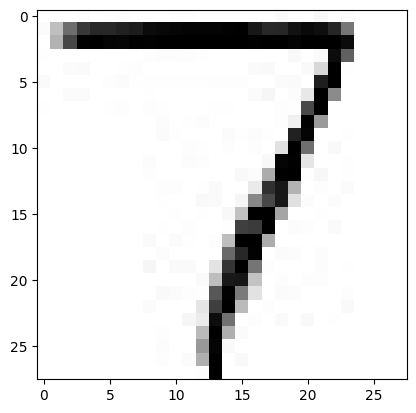

In [ ]:
img = cv2.imread('/content/seven.jpg')
img = cv2.resize(img, (28,28))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img= cv2.bitwise_not(img) # invert image
plt.imshow(img, cmap = plt.cm.binary)

img = img.astype(np.float32)
img = img/255
img = (img-0.1307)/0.3081

img = np.expand_dims(img, 0)
img = np.expand_dims(img, 0)
img = torch.from_numpy(img).to(device)

# warmup for 10 times
for _ in range(10):
    tmp = torch.randn(1,3,640,640).to(device)
    binding_addrs['images'] = int(tmp.data_ptr())
    context.execute_v2(list(binding_addrs.values()))

start = time.perf_counter()
binding_addrs['images'] = int(img.data_ptr())
context.execute_v2(list(binding_addrs.values()))
print(f'Cost {time.perf_counter()-start} s')

outputs = bindings['output0'].data

print ("Output shape = {}".format(outputs.shape))

pred = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
pred = pred.detach().cpu().numpy()

print ("Charecter is ➡ {} ".format(pred.flatten()[0]))